# Modeling

## Imports

In [1]:
#File and name management libraries
import os
import shutil
import glob
from pathlib import Path

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import datetime
import matplotlib.dates as mdates
from datetime import datetime, timedelta

#Assocations and correlations libraries
import ppscore as pps

#Machine learning libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pycaret.regression import *

#Other file format libraries
#!pip install xlsxwriter
import xlsxwriter

In [2]:
from pycaret.utils import version
print('Pycaret Version: ', version())

Pycaret Version:  3.0.0.rc4


# Targe feature

In [3]:
#Set the target feature
TARGET_FEATURE = 'wti_price'

In [4]:
#Set prediction timeline and models {month: file_name}
models = {
        "1":{
            'model_file': 'regression_model_1m'},
    
        "2":{
            'model_file': 'regression_model_2m'},
    
        "3":{
            'model_file': 'regression_model_3m'},

        "4":{
            'model_file': 'regression_model_4m'},
    
        "5":{
            'model_file': 'regression_model_5m'},
    
        "6":{
            'model_file': 'regression_model_6m'},
        }
        

## Load Models

In [5]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [6]:
#define folder
m_path = ROOT_DIR + '\\models\\'

#cast pipelines to a dict
for key,value in models.items():
    #get the file name
    model_name = models[key]['model_file']

    #read final model metrics and store in the dict
    excel_file = m_path + model_name + '\\pycaret_tables.xlsx'
    models[key]['metrics'] = pd.read_excel(open(excel_file, 'rb',),index_col = 0, sheet_name='pred_final')

    #load pipeline
    finalized_model = load_model(m_path + model_name)
    
    #cast the pipeline to the dict item with proper key 
    models[key]['pipeline'] = finalized_model

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


## Load Data

In [7]:
#Define file name and location
dataset_csv = 'step3_eda_wti_price.csv'
f_path = '\\data\\interim\\'

#Set file name and location
f = ROOT_DIR + f_path + dataset_csv
print(f)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\step3_eda_wti_price.csv


In [8]:
#cast csv to dataframe
df = pd.read_csv(f)

#set Date as index
df.set_index('Date', drop=True, inplace=True)

#convert 'Date' column to date format
df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors="raise")

#print shape of dataframe
print('Shape:',df.shape)

#display df head
display(df.tail(7).round(2))

Shape: (269, 30)


,wti_price,oil_production_opec,oil_production_nonopec,oil_production_world,henry_hub_ng_price,oil_production_us,petrol_consumption_oecd,petrol_consumption_nonoecd,us_cpi,us_ppi,...,global_econ_policy_uncert_index,comp,copper_futures,djia,dxy,gold_futures,spx,wti_brent_price_spread,wti_crack_spread,brent_crack_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,71.71,27.87,64.94,95875.83,3.76,11.63,47.68,54.63,2.80,2.45,...,263.15,15474.43,4.46,35641.33,95.97,1829.7,4674.77,-2.46,472.97,465.59
2022-01-01,83.22,27.82,64.70,95847.26,4.38,11.37,44.65,52.93,2.82,2.48,...,232.73,14531.38,4.33,35456.15,96.54,1796.4,4573.82,-3.29,489.94,480.07
2022-02-01,91.64,28.58,64.91,96799.26,4.69,11.32,46.76,53.97,2.84,2.53,...,189.55,13898.73,4.45,34648.48,96.71,1902.2,4435.98,-5.49,535.88,519.41
2022-03-01,108.50,28.22,65.75,97183.81,4.90,11.70,46.23,52.58,2.88,2.58,...,330.53,13623.26,4.75,34029.74,98.31,1954.0,4391.27,-8.75,679.10,652.85
2022-04-01,101.78,28.59,64.68,96325.69,6.60,11.67,44.73,52.66,2.89,2.70,...,291.26,13394.16,4.41,34314.99,102.96,1915.1,4391.30,-2.80,742.20,733.80
2022-05-01,109.55,28.10,65.05,96169.41,8.14,11.63,45.18,53.33,2.91,2.74,...,288.91,11829.73,4.30,32379.46,101.75,1848.4,4040.36,-3.83,866.96,855.47
2022-06-01,114.84,28.38,64.82,96792.86,7.70,11.79,46.36,54.11,2.95,2.76,...,268.76,11418.92,3.71,31446.71,104.68,1812.0,3898.95,-7.87,914.95,891.34


## Analyze the Performance of Final Models on Entire Dataset

### Functions

In [9]:
def plot_distribution(pred_final, target_feature):
    # An interesting view is looking at the Actual Values and Predicted Values (Label) in 
    #a histogram over the entire dataset. This shows the distribution between the values.
    #We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 

    plt.figure(figsize=(15,5))
    sns.set_style("whitegrid")
    sns.distplot(pred_final[target_feature],
                    bins=20,
                    kde=False,
                    color="#c6690c")
    
    sns.distplot(pred_final["prediction_label"],
                    bins=20,
                    kde=False,
                    color="#664697")
    
    plt.title("Distribution between Actual Value and Predicted Value")
    plt.ylabel("Count")
    plt.xlabel("WTI Price")
    plt.legend(('Actual Value', 'Predicted Value'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [10]:
def plot_actual_vs_predict(pred_final, target_feature):
    # We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
    sns.regplot(x=target_feature, y="prediction_label",
                data=pred_final,
                lowess=False, 
                scatter_kws ={'s':50}, 
                line_kws={"color": "#664697"},
                color="#c6690c")

    plt.title("Linear Relationship between Actual Value and Predicted Value")
    plt.ylabel("Predicted Value")
    plt.xlabel("Actual Value")
    plt.legend(('Best Fit', 'Actual Value vs Predicted Value'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [11]:
def plot_residuals(pred_final, target_feature):
    # We can compare the Predicted Values (Label) and Residuals in an error plot over the entire dataset. 
    sns.residplot(x="wti_price", y="prediction_label",
                  data=pred_final,
                  lowess=False,
                  scatter_kws ={'s':50},
                  line_kws={"color": "#664697"},
                  color="#c6690c")

    plt.title("Residuals for the Predicted values in Final Model")
    plt.ylabel("Residuals")
    plt.xlabel("Predicted Value")
    #plt.xlim((74,101))
    plt.legend(('Best Fit', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [12]:
def shift_column_df (df, column, shift_val):
    '''shift a column of dataframe by shif_val'''
    
    df_shift = df.copy()
    df_shift[column] = df_shift[column].shift(shift_val)
    df_shift.dropna(axis = 0, inplace = True)
    return df_shift

In [13]:
def describe_pred(df, actual_col, pred_col):
    df['redisual'] = np.abs(df[actual_col] - df[pred_col])
    display(df[[actual_col, pred_col, 'redisual']].describe())

In [14]:
def rmse(df, actual_col, pred_col):    
    rmse = ((df[actual_col] - df[pred_col]) ** 2).mean() ** .5
    return rmse

## Display the final models

In [15]:
# Dispaly pipelines
for key, value in models.items():
    print('month = ', key)
    
    display(models[key]['pipeline'])

month =  1


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                            num_leaves=256,
                                                            random_state=786,
                                                            reg_alpha=0.005,
                                                            reg_lambda=5)),
                                             ('Random Forest Regressor',
                                              RandomForestRegressor(bootstrap=False,
                                                                    criterion='mse',
                                                                    max_depth=8,
                                                                    max_features='log2',
                                                                    min_impurity_decrease=0.0001,
                                                                    min_samples_leaf=3,
                                                                    min_samples_split=5,
                                                                    n_estimators=260,
                                                                    n_jobs=-1,
                                                                    random_state=786)),
                                             ('AdaBoost Regressor',
                                              AdaBoostRegressor(random_state=786))],
                                 n_jobs=-1))])

month =  2


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                              feature_fraction=0.9,
                                                              learning_rate=0.05,
                                                              min_child_samples=6,
                                                              min_split_gain=0.5,
                                                              n_estimators=140,
                                                              num_leaves=50,
                                                              random_state=786,
                                                              reg_alpha=0.5,
                                                              reg_lambda=0.7)),
                                               ('AdaBoost Regressor',
                                                AdaBoostRegressor(learning_rate=0.5,
                                                                  loss='exponential',
                                                                  n_estimators=270,
                                                                  random_state=786))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

month =  3


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                            learning_rate=0.05,
                                                            min_child_samples=6,
                                                            min_split_gain=0.2,
                                                            n_estimators=280,
                                                            num_leaves=150,
                                                            random_state=786,
                                                            reg_alpha=5,
                                                            reg_lambda=0.01)),
                                             ('Random Forest Regressor',
                                              RandomForestRegressor(bootstrap=False,
                                                                    criterion='mse',
                                                                    max_depth=6,
                                                                    max_features='log2',
                                                                    min_impurity_decrease=0.01,
                                                                    min_samples_leaf=2,
                                                                    n_estimators=230,
                                                                    n_jobs=-1,
                                                                    random_state=786))],
                                 n_jobs=-1))])

month =  4


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                              feature_fraction=0.8,
                                                              learning_rate=0.3,
                                                              min_child_samples=6,
                                                              min_split_gain=0.8,
                                                              n_estimators=200,
                                                              num_leaves=10,
                                                              random_state=786,
                                                              reg_alpha=1,
                                                              reg_lambda=0.0001)),
                                               ('AdaBoost Regressor',
                                                AdaBoostRegressor(learning_rate=0.3,
                                                                  loss='square',
                                                                  n_estimators=190,
                                                                  random_state=786))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

month =  5


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                                      criterion='mse',
                                                                      max_depth=8,
                                                                      max_features='log2',
                                                                      min_impurity_decrease=0.0001,
                                                                      min_samples_leaf=3,
                                                                      min_samples_split=5,
                                                                      n_estimators=260,
                                                                      n_jobs=-1,
                                                                      random_state=786)),
                                               ('AdaBoost Regressor',
                                                AdaBoostRegressor(learning_rate=0.3,
                                                                  loss='square',
                                                                  n_estimators=190,
                                                                  random_state=786))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

month =  6


Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                                  random_state=786)),
                                               ('Light Gradient Boosting '
                                                'Machine',
                                                LGBMRegressor(bagging_fraction=1.0,
                                                              bagging_freq=5,
                                                              feature_fraction=0.6,
                                                              learning_rate=0.15,
                                                              min_child_samples=16,
                                                              min_split_gain=0.8,
                                                              n_estimators=300,
                                                              num_leaves=50,
                                                              random_state=786,
                                                              reg_alpha=1e-06,
                                                              reg_lambda=0.1))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

In [16]:
models[key]['metrics']['RMSE']

0    2.2829
Name: RMSE, dtype: float64

### Analyze the Performance of Final Model on Entire Dataset

regression_model_1m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.5421,3.8317,1.9575,0.9943,0.0384,0.0278


,wti_price,prediction_label,redisual
count,268.000000,268.000000,268.000000
mean,62.169331,62.147213,1.542101
std,25.958231,25.391589,1.207919
min,16.549999,21.568292,0.005412
25%,41.076501,42.301213,0.617973
50%,59.061501,58.357929,1.337155
75%,81.995499,81.386597,2.207553
max,133.880005,128.221459,6.674372


RMSE = 1.9574727505990286


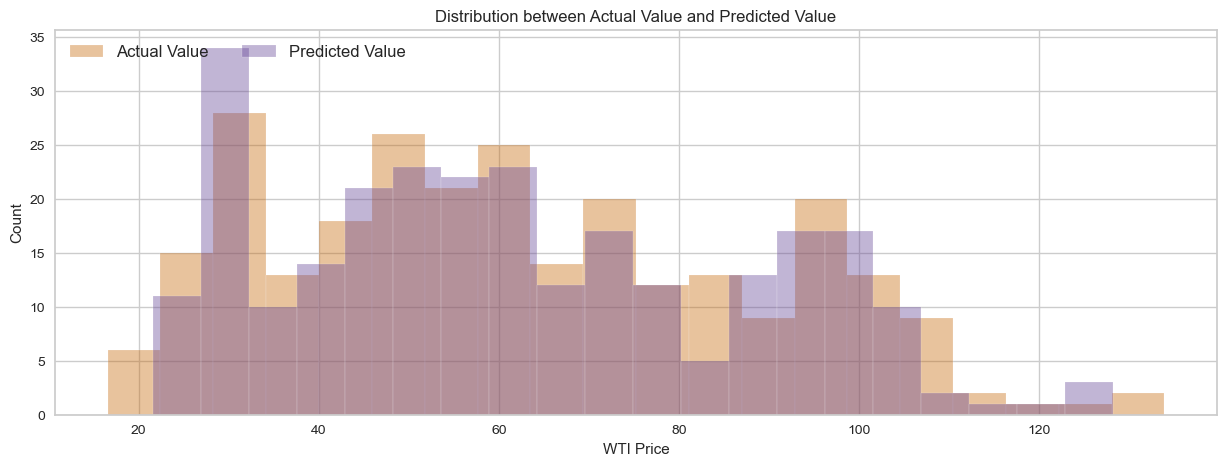

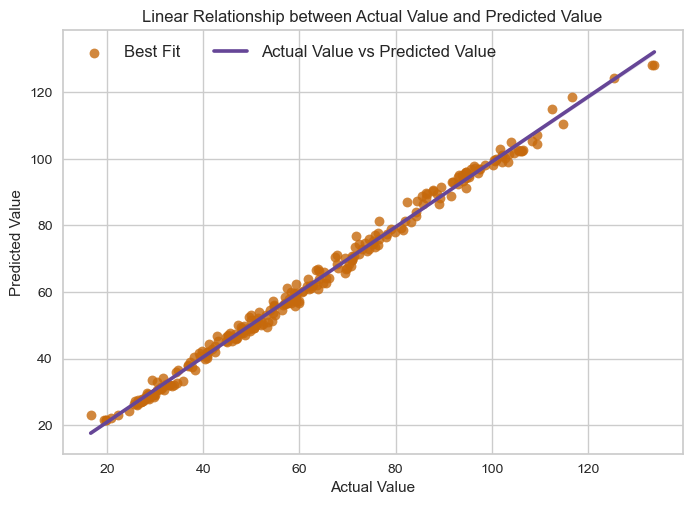

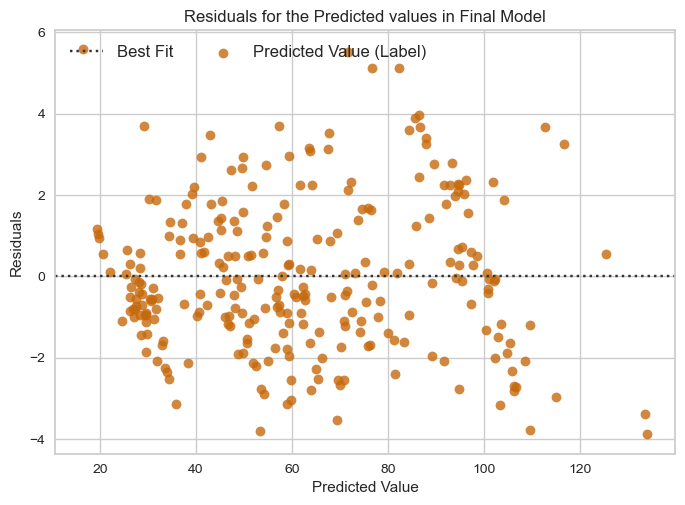


regression_model_2m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.2839,4.018,2.0045,0.994,0.0337,0.0211


,wti_price,prediction_label,redisual
count,267.000000,267.000000,267.000000
mean,62.290409,62.295459,1.283877
std,25.931053,25.895901,1.542264
min,16.549999,19.389000,0.000000
25%,41.416000,42.479660,0.246525
50%,59.083000,59.242160,0.689147
75%,82.098000,80.765800,1.766834
max,133.880005,133.684915,9.027959


RMSE = 2.004497310304932


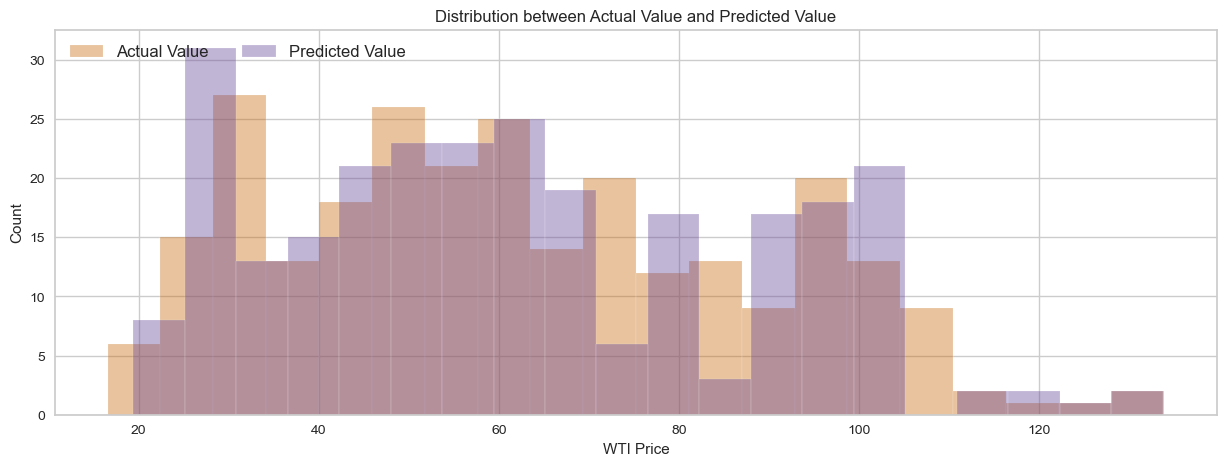

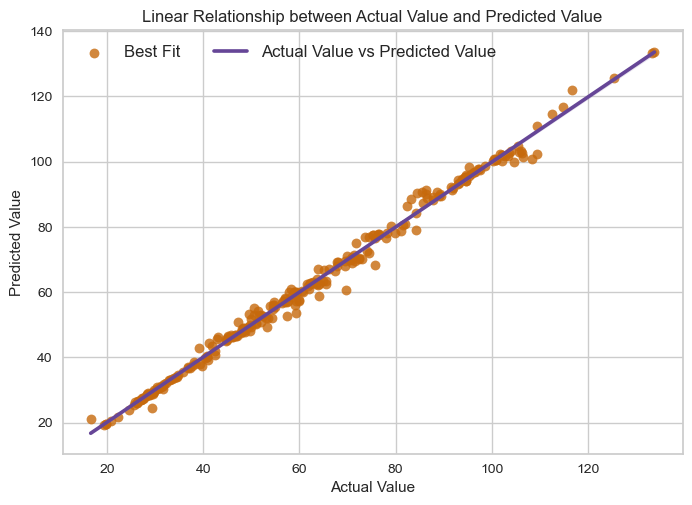

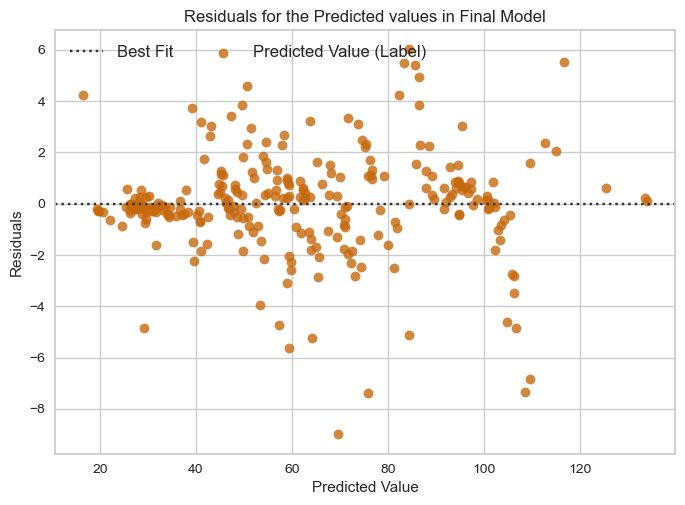


regression_model_3m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.6065,4.2426,2.0598,0.9936,0.0386,0.0292


,wti_price,prediction_label,redisual
count,266.000000,266.000000,266.000000
mean,62.427879,62.393514,1.606461
std,25.882271,25.098826,1.291563
min,16.549999,21.061223,0.004683
25%,41.867499,44.993013,0.567926
50%,59.174000,59.165272,1.346602
75%,82.200500,82.105761,2.269902
max,133.880005,132.116985,6.149143


RMSE = 2.059752826321202


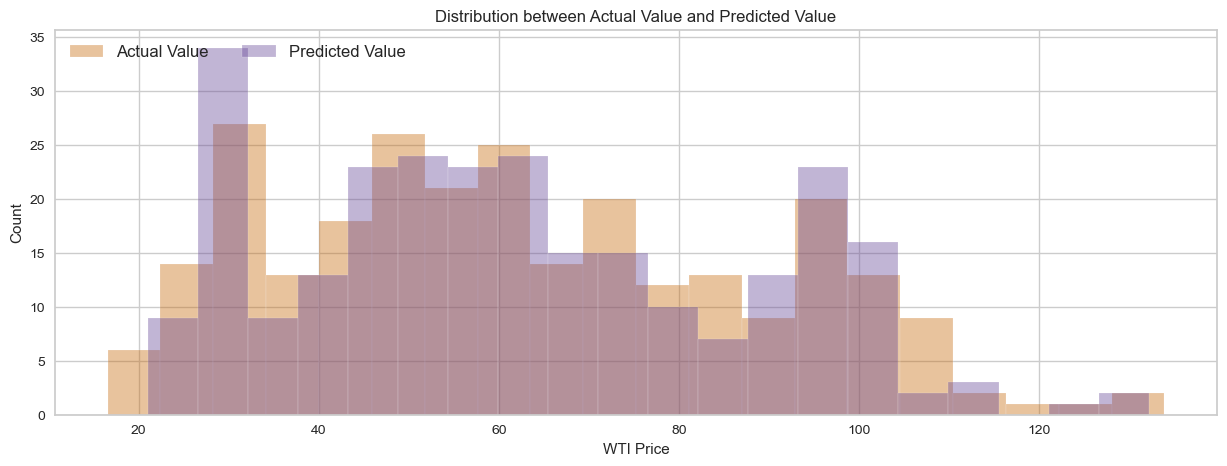

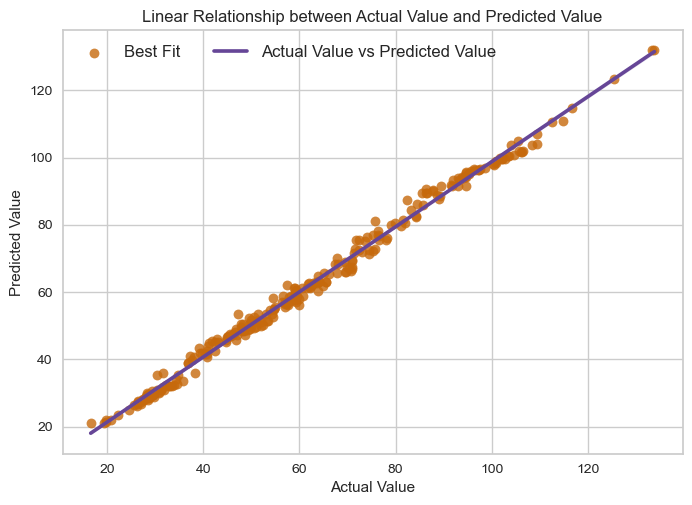

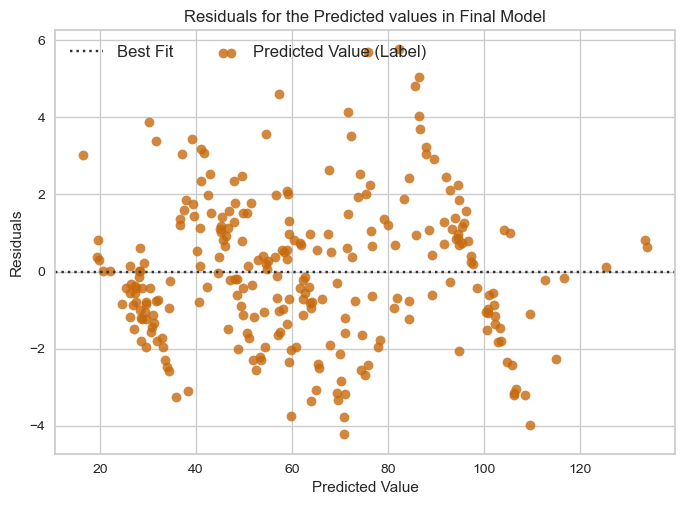


regression_model_4m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.1033,2.9955,1.7308,0.9955,0.0342,0.0192


,wti_price,prediction_label,redisual
count,265.000000,265.000000,265.000000
mean,62.554829,62.578813,1.103292
std,25.848143,26.004725,1.336032
min,16.549999,19.767960,0.000000
25%,42.340000,40.922730,0.256149
50%,59.264999,59.669060,0.686558
75%,82.303001,81.206440,1.589601
max,133.880005,133.880005,12.055332


RMSE = 1.7307507034678398


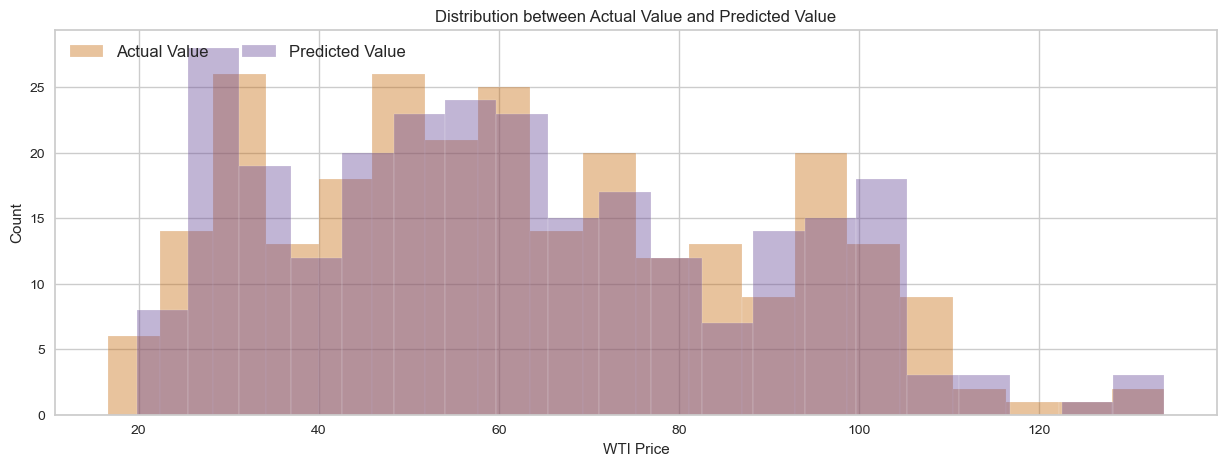

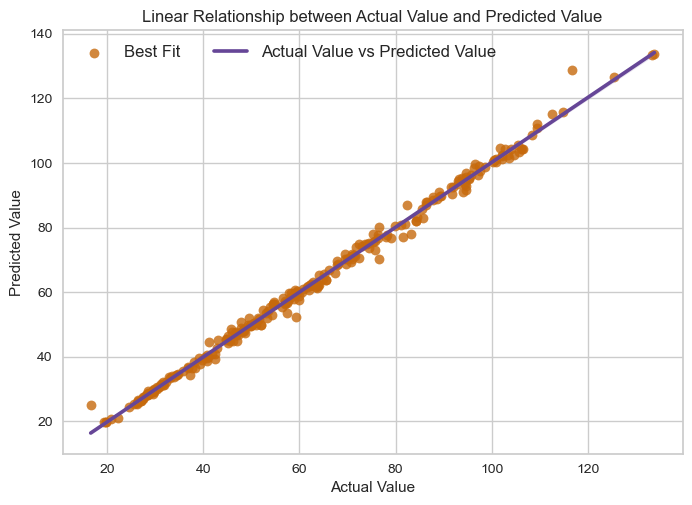

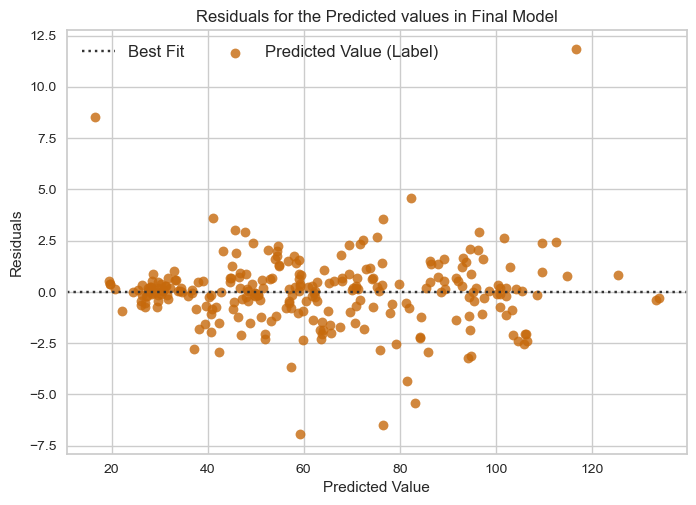


regression_model_5m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.3609,4.1832,2.0453,0.9937,0.0376,0.0236


,wti_price,prediction_label,redisual
count,264.000000,264.000000,264.000000
mean,62.671238,62.705175,1.360901
std,25.827553,25.880434,1.529702
min,16.549999,20.419430,0.009170
25%,42.417251,43.859186,0.332625
50%,59.271999,59.483555,0.883235
75%,82.532251,82.523330,1.774799
max,133.880005,132.370545,8.618663


RMSE = 2.0452809017944875


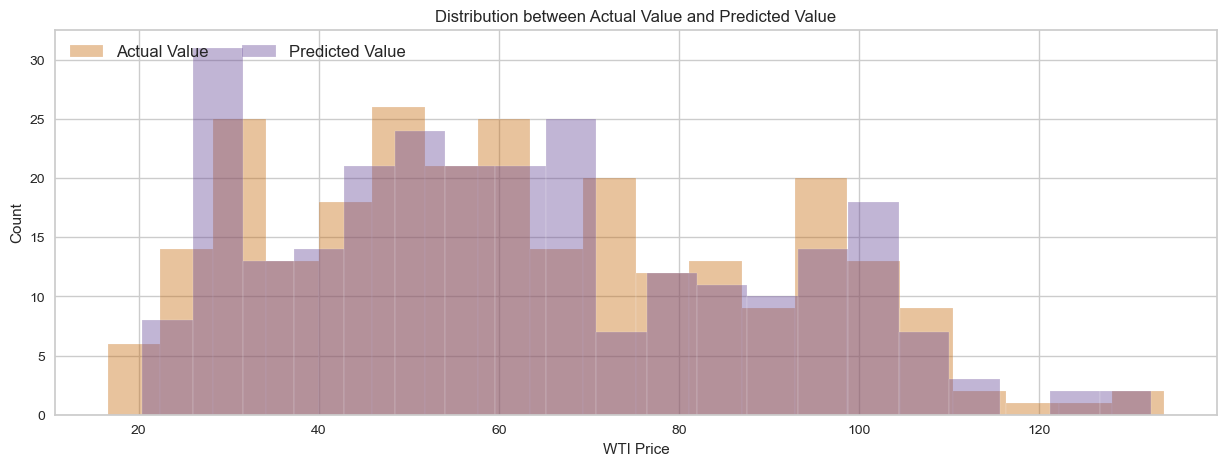

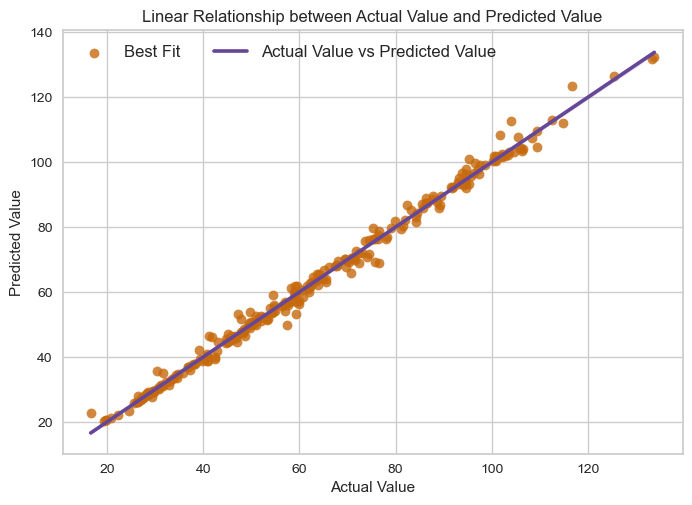

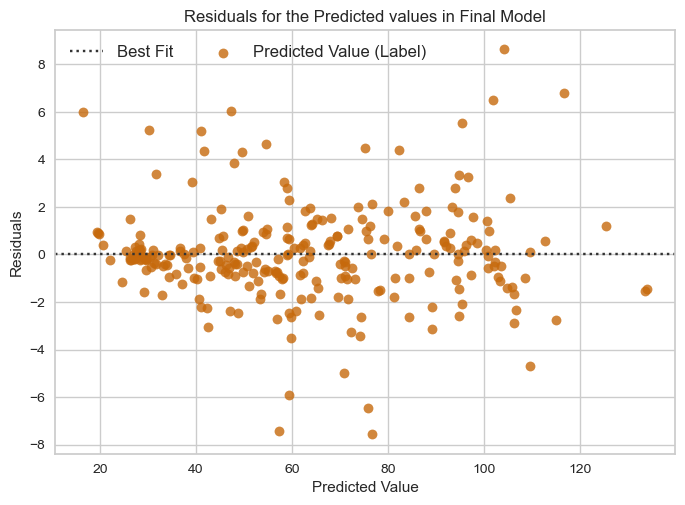


regression_model_6m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.3982,5.2116,2.2829,0.9921,0.0441,0.0238


,wti_price,prediction_label,redisual
count,263.000000,263.000000,263.000000
mean,62.796616,62.961775,1.398208
std,25.796164,26.100669,1.808051
min,16.549999,19.623970,0.000940
25%,42.655001,42.438950,0.228420
50%,59.278999,60.490191,0.745809
75%,82.761501,85.302865,1.801019
max,133.880005,133.710365,12.255147


RMSE = 2.2828937885840843


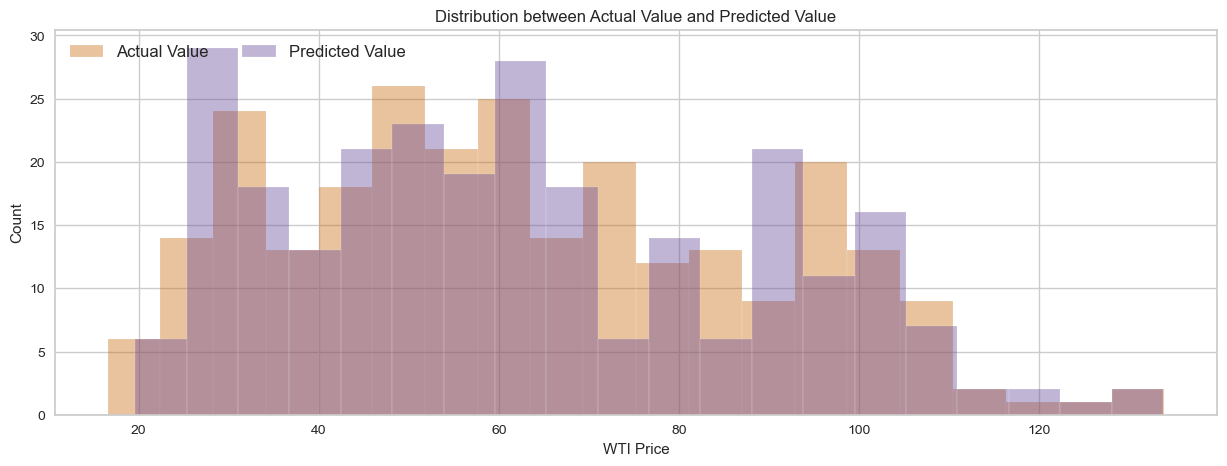

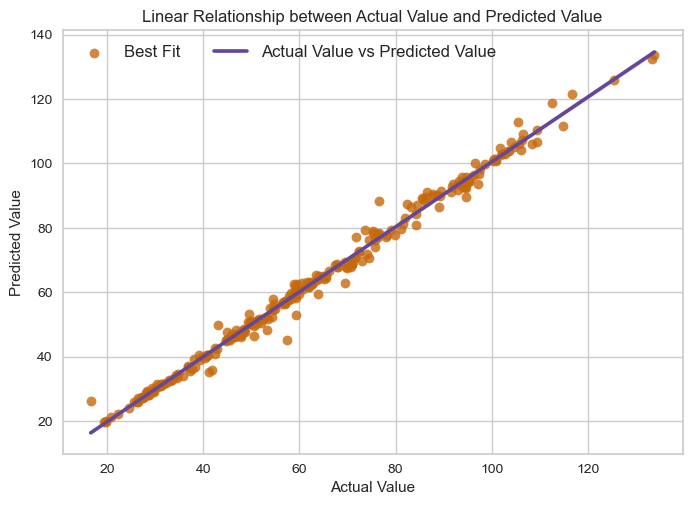

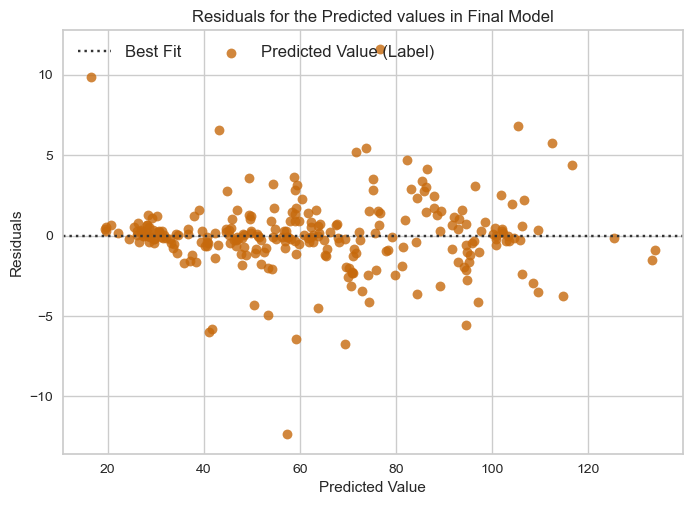

In [17]:
for key, value in models.items():
    
    #gt the model name
    model_name = models[key]['model_file']
    print(model_name)
        
        
    #get the model pipelibe
    pipeline = models[key]['pipeline']
    display(models[key]['metrics'])
    
    
    #Sift the TARGET_FEATURE to dataframe by n-month
    df_shift = shift_column_df(df, TARGET_FEATURE, -1*int(key))
    
    
    #Apply predict_model() on the dataframe 
    prediction = predict_model(pipeline, data=df_shift, verbose = True)
    
    
    #Dscribe prediction
    describe_pred(prediction, TARGET_FEATURE, 'prediction_label')
    print('RMSE =', rmse(prediction, TARGET_FEATURE, 'prediction_label'))
    
    
    #generate pred_scenarion name and store predictions
    pred_scenario = 'pred_' + str(key) + 'm'
    globals()[pred_scenario] = prediction
    
    
    #plot predictions
    plot_distribution(prediction, TARGET_FEATURE)
    plot_actual_vs_predict(prediction, TARGET_FEATURE)
    plot_residuals(prediction, TARGET_FEATURE)
        
    print('')


In [18]:
#Save prediction to excel file
with pd.ExcelWriter(m_path + '\\pred_tables.xlsx', engine='xlsxwriter') as writer:
    # Write each dataframe to one ksheet.
    for key, value in models.items():
        pred_scenario  = 'pred_' + str(key) + 'm'
        globals()[pred_scenario].to_excel(writer, sheet_name=pred_scenario)

## Vizualize Predictions

### Extend Date index for predicted months

In [19]:
#Date range from reading files
dates_read_df = pd.DataFrame(df.index)

In [20]:
#Find the the last date in dates
lst = list(models.items())
last_date = list(dates_read_df['Date'])[-1]
base = str(last_date).split(' ')[0]
print(base)

2022-06-01


In [21]:
#Extend date index for predicted persions
#start date
start_dt = datetime.strptime(base, "%Y-%m-%d").replace(day=1)
start_dt = start_dt + timedelta(days=1)

#end date
numdays = int(lst[-1][0])*31
end_dt = start_dt + timedelta(days=numdays)
end_dt = end_dt.replace(day=1)

In [22]:
#Check the newly added "Dates"
dates_new_df = pd.DataFrame(pd.date_range(start=start_dt, end=end_dt, freq = 'MS'), columns = ['Date'])

In [23]:
#append the newly added dates to the dates from data reader
dates_extend = pd.concat([dates_read_df, dates_new_df], axis=0)

In [24]:
#Case the corresponsing date data on extended df (using merge on 'Date)
dates_extend_df = dates_extend.merge(df[TARGET_FEATURE], on = 'Date', how = 'outer')

### Cast predictions to the dataframe

In [25]:
for key, value in models.items():
    print('month: ', key)
    pipeline = models[key]['pipeline']
    
    # Use predict_model() to calcluate prediction labels
    prediction = predict_model(pipeline, data=df)
    
    #create a column name for each model
    column_name = 'prediction_' + key + 'm'
    df_new = prediction[['prediction_label']]
    df_new = df_new.rename(columns={'prediction_label': column_name}, errors="raise")
    
    #Case the corresponsing date data on extended df (using merge on 'Date)
    dates_extend_df = dates_extend_df.merge(df_new, on = 'Date', how = 'outer')
    
    #since we shifted n-month data by "n" for modeling, here we need to "shift back" the data for visualization
    dates_extend_df[column_name] = dates_extend_df[column_name].shift(int(key))


month:  1
month:  2
month:  3
month:  4
month:  5
month:  6


In [26]:
#Check the exetnded date df with predictions from modelling
display(dates_extend_df.head(7))
display(dates_extend_df.tail(7))

,Date,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m
0,2000-02-01,29.366,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-03-01,29.842,29.205892,NaN,NaN,NaN,NaN,NaN
2,2000-04-01,25.722,27.247651,26.45358,NaN,NaN,NaN,NaN
3,2000-05-01,28.788,29.160521,28.87754,29.434562,NaN,NaN,NaN
4,2000-06-01,31.822,30.472888,31.85918,30.993794,31.37148,NaN,NaN
5,2000-07-01,29.697,29.530373,30.09670,29.947539,30.09951,29.66103,NaN
6,2000-08-01,31.264,30.958946,31.14969,30.928926,31.46594,30.96325,31.48683


,Date,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m
268,2022-06-01,114.84,110.562859,116.675570,110.803302,115.830441,112.046920,111.647340
269,2022-07-01,NaN,103.524687,109.620168,106.407496,101.180649,105.420569,104.634939
270,2022-08-01,NaN,NaN,109.205378,104.514948,101.362949,96.745290,107.870009
271,2022-09-01,NaN,NaN,NaN,102.808685,97.735589,95.934510,98.571690
272,2022-10-01,NaN,NaN,NaN,NaN,93.021119,85.610910,95.869620
273,2022-11-01,NaN,NaN,NaN,NaN,NaN,86.850140,89.610171
274,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,93.531171


## Plot predictions

### Process the data for plotting

In [27]:
df_plot = dates_extend_df.copy()

#convert 'Date' column to date format
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df_plot.set_index('Date', drop=True, inplace=True)

In [28]:
#melt data for creating plot-ready dataframe
df_melt = pd.melt(df_plot, var_name=None, value_name='value', col_level=None, ignore_index=False)

In [29]:
#reset index and move "date" from index to a column
df_plot_preds = df_melt.reset_index()
df_plot_preds

,Date,variable,value
0,2000-02-01,wti_price,29.366000
1,2000-03-01,wti_price,29.842000
2,2000-04-01,wti_price,25.722000
3,2000-05-01,wti_price,28.788000
4,2000-06-01,wti_price,31.822000
...,...,...,...
1920,2022-08-01,prediction_6m,107.870009
1921,2022-09-01,prediction_6m,98.571690
1922,2022-10-01,prediction_6m,95.869620
1923,2022-11-01,prediction_6m,89.610171


### Plot functions

In [30]:
def relplot_preds(plt_df, title = None, hue = "variable", style = "variable"):
    sns.relplot(x="Date",
        y="value",
        data=plt_df,
        kind="line",
        style=style,
        hue=hue,
        height = 4,
        aspect = 3).set(title=title)
    plt.show()

### Plots

##### All data

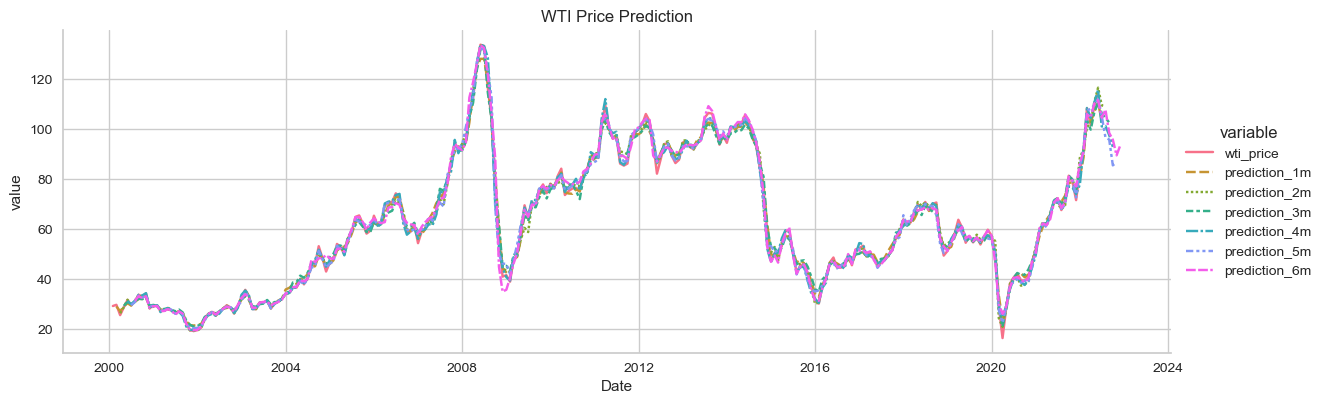

In [31]:
relplot_preds(df_plot_preds, 'WTI Price Prediction')

##### Zoomed in

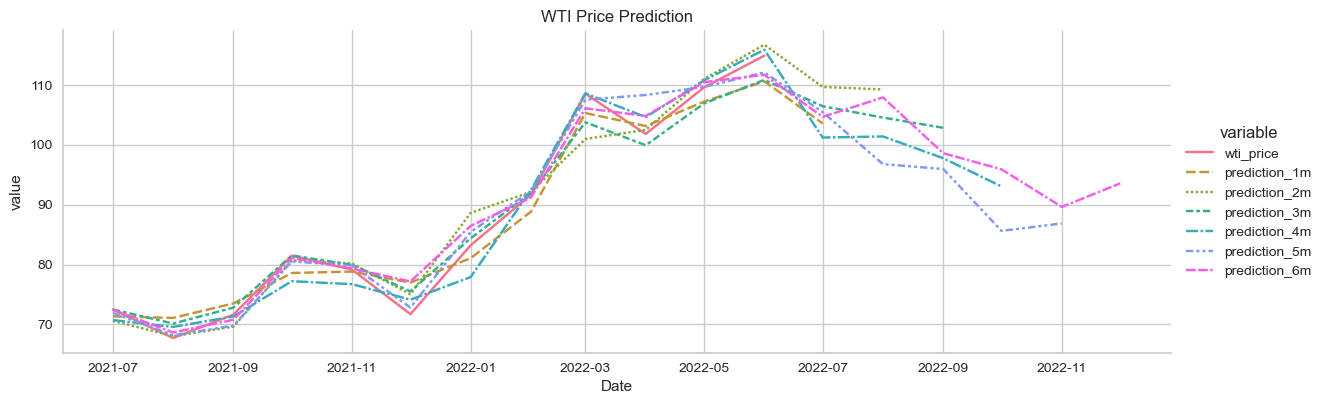

In [32]:
date_zoom_in = '2021-06-01'
df_plot_2020 = df_plot_preds.loc[df_plot_preds['Date'] > date_zoom_in]
relplot_preds(df_plot_2020, 'WTI Price Prediction')

## Calculate Expected Average

### Functions

In [33]:
def calculate_weights(size):
    weights = size * [0]
    weights[0] = 1
    for i in range(1,size):
        weights[i] =  weights[i-1]/2.0
    return weights

In [34]:
def power(my_list, p):
    return [ x**p for x in my_list]

### Calclute weighted mean

In [35]:
#Make a copy to store average predictions
df_average = dates_extend_df.copy()

In [36]:
#Get all RMSE values from models and append to "remse_all"
rmse_all = []
for key, value in models.items():
    rmse_val = np.float(models[key]['metrics']['RMSE'][0])
    rmse_all.append(rmse_val)
    
rmse_all

[1.9575, 2.0045, 2.0598, 1.7308, 2.0453, 2.2829]

### Calculate weights

In [37]:
#Calcluate weight as 1/RMSE
weights = power(rmse_all, -1)

In [38]:
#Multiplt predictions from models by the "weights"
weights_df = dates_extend_df.notnull().iloc[:,2:]*weights
weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)

#Calclate weighted mean of predictions
df_average['avg_prediction'] = (df_average.iloc[:,2:]*weights_df).sum(axis=1)

In [39]:
#Calcluate RMSE of 
rmse(df_average, TARGET_FEATURE, 'avg_prediction')

2.2569485953406

### Calcalte average RMSE and upper and lower bounds

In [40]:
#Calcluate average RMSE of multiple models
count_rmse = dates_extend_df.notnull().iloc[:,2:].sum(axis=1)
df_average['avg_rmse'] = np.sqrt(sum(power(rmse_all,2))/count_rmse)

1.96 is used because the 95% confidence interval has only 2.5% on each side. The probability for a z score below −1.96 is 2.5%, and similarly for a z score above +1.96; added together this is 5%. 1.64 would be correct for a 90% confidence interval, as the two sides (5% each) add up to 10%.

In [41]:
from scipy.stats import norm
alpha = 1-0.05/2
z = norm.ppf(alpha)

In [42]:
df_average['upper_bound'] = df_average['avg_prediction'] + df_average['avg_rmse'] * z
df_average['lower_bound'] = df_average['avg_prediction'] - df_average['avg_rmse'] * z

## Visualizaiton and concept

### Prepare data

In [43]:
df_plot_avg = df_average.copy()

#convert 'Date' column to date format
df_plot_avg['Date'] = pd.to_datetime(df_plot_avg['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df_plot_avg.set_index('Date', drop=True, inplace=True)

In [44]:
#Predictiion and upper/lower bounds for feilds with no 'wti_price' values
is_predicted = df_plot_avg[TARGET_FEATURE].isnull()

#replace exising 'wti_price' with known values
df_plot_avg['avg_prediction'].loc[~is_predicted] = df_plot_avg[TARGET_FEATURE]
df_plot_avg['upper_bound'].loc[~is_predicted] = np.nan
df_plot_avg['lower_bound'].loc[~is_predicted] = np.nan
df_plot_avg['upper_bound'].loc[df_plot_avg.index == base] = df_plot_avg[TARGET_FEATURE]
df_plot_avg['lower_bound'].loc[df_plot_avg.index == base] = df_plot_avg[TARGET_FEATURE]

### Final plot with upper and lower bounds

In [45]:
#melt data for creating plot-ready dataframe
df_melt_avg = pd.melt(df_plot_avg,
                      var_name=None,
                      value_vars = ['avg_prediction', 'upper_bound', 'lower_bound'],
                      value_name='value',
                      col_level=None,
                      ignore_index=False)

In [46]:
#reset index and move "date" from index to a column
df_plot_avg = df_melt_avg.reset_index()

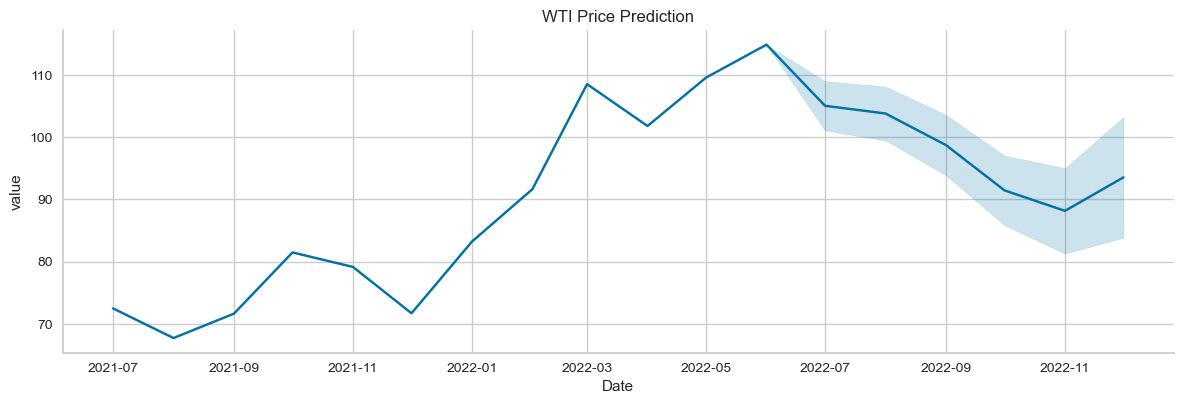

In [47]:
final_dates_to_plot = df_plot_avg.loc[df_plot_avg['Date'] > date_zoom_in]
relplot_preds(final_dates_to_plot, 'WTI Price Prediction', hue = None, style = None)